In [1]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag import pos_tag

In [2]:
!pip install spacy


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 23.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install -q efficientnet


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install --upgrade numpy


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# !pip uninstall tensorflow

In [7]:
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install googletrans==3.1.0a0


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!pip install langid


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
!pip install opencv-python-headless


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import numpy as np 
import pandas as pd
import random
import math
import re
import os
import langid
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread as imread
from skimage.util import montage
from skimage.color import label2rgb
import cv2
from sklearn.model_selection import train_test_split
import googletrans
from googletrans import Translator
translator = Translator()
import ast
import json
import spacy

# Load the English language model in spacy
nlp = spacy.load('en_core_web_sm')

# Define batch size
batch_size = 100

In [12]:
# import warnings
# import pandas as pd

# # Turn off the SettingWithCopyWarning
# warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

In [13]:
import tensorflow as tf
# import tensorflow.keras.applications as tfka
# import efficientnet.tfkeras as efn

### Functions

In [14]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

# Function to preprocess the recipe and retain only nouns
def preprocess_recipe(recipe):
    doc = nlp(recipe)
    filtered_tokens = []
    for token in doc:
        # Exclude tokens identified as punctuation, stop words, and measurement units
        if token.pos_ == 'NOUN' and token.text.lower() not in {'cup', 'cups', 'tablespoon', 'tablespoons', 'teaspoon', 'teaspoons', 'ounce', 'ounces', 'inch'
                                                               , 'inches', 'pound', 'pounds', 'slice', 'slices', 'white', 'fresh', 'grated', 'leaves', 'cut'
                                                               , 'thinly', 'ground', 'medium', 'plus', 'serving', 'chopped', 'large', 'finely',
                                                              'room temperature', 'lb', 'tsp', 'tsp.', 'tbsp', 'tbsp.', 'oz', 'Pinch', 'diameter'
                                                              , 'pieces', 'powder'} and '/' not in token.text:
            filtered_tokens.append(token.text)
    return ' '.join(filtered_tokens)

# Function to plot word frequencies
def plot_word_frequencies(df, column_name):
    # Flatten the list of words from the specified column
    all_words = ' '.join(df[column_name]).split()
    
    # Create a Pandas Series to count the frequency of each word
    word_freq = pd.Series(all_words).value_counts().sort_values(ascending=False)
    
    # Plot the top 20 most frequent words
    plt.figure(figsize=(10, 6))
    word_freq.head(20).plot(kind='bar')
    plt.title('Top 20 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
    
# Google translate
def to_translate(original_text):
    langs = translator.detect(original_text)
    print(langs.lang, langs.confidence)
    new_titlename = original_text
    if langs.confidence>0.6:
        totranslate = translator.translate(original_text, dest='en')
        sourcelang = googletrans.LANGUAGES.get(totranslate.src, totranslate.src)
        print(f'Converting from {sourcelang} to english.')
        new_titlename = totranslate.text
    return new_titlename

# Define a function to check for non-English alphabet characters
# To make the pattern more inclusive of various characters commonly used in English, using Unicode character properties
# Tried r'[^\x00-\x7F]' first; wasn't recognizing accents, etc.\u0000-\u007F. Trying Latin-1 Supplement: \x00-\xFF
# Basic Latin Unice: P{IsBasicLatin}
def contains_english(text):    
#     return bool(re.search(r'[^A-Za-z\sÀ-ÿ]', text))
    b=langid.classify(text)[0] == 'en'
    return b

# Define a function to check for english alphabet characters
def is_english_word(word):
    for char in word:
        if not unicodedata.category(char).startswith('L'):
            return False
    return True

In [15]:
seed=42
seed_everything(seed)

In [16]:
def image_mapping_check(dataset):
    counter = 0
    record = []

    while counter < dataset.shape[0]-1:
        row = dataset.loc[counter]
        print(row, counter)
        img_name = row['Image_Name']
        img = cv2.imread(img_path+img_name+'.jpg')
        try:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
        except:
            record.append(counter)
        counter+= 1
    print(record.shape)
#     new = dataset.drop(record, axis = 0)
#     new = new.reset_index(drop = True)
#     return new

def allergens_mapping(row, types):
    for item in common_allergens[types]:
        if item.lower() in row.lower():
                return 1
    return 0

def combination(row):
    return(row['milk'], row['meat'], row['eggs'], row['tree nuts'], row['peanuts'], row['shellfish'], row['wheat'], row['soy'], row['fish'])

def vegan(row):
     return (
        not row['milk'],
        not row['meat'],
        not row['eggs'],
        not row['shellfish'],
        not row['fish']
    )

def vegetarian(row):
     return (
        not row['meat'],
        not row['eggs'],
        not row['shellfish'],
        not row['fish']
    )
    
def meat(row):
    return (
        row['meat']
    )

def pescatarian(row):
    return (
        not row['meat'],
        not row['shellfish']
    )

def load_allergen_data(df):
    df = image_mapping_check(df)
    df['milk'] = df[df['Type']=='Cleaned Ingredients']['Recipe'].apply(lambda x: allergens_mapping(x, types = 'milk'))
    df['meat'] = df[df['Type']=='Cleaned Ingredients']['Recipe'].apply(lambda x: allergens_mapping(x, types = 'meat'))    
    df['eggs'] = df[df['Type']=='Cleaned Ingredients']['Recipe'].apply(lambda x: allergens_mapping(x, types = 'eggs'))
    df['tree nuts'] = df[df['Type']=='Cleaned Ingredients']['Recipe'].apply(lambda x: allergens_mapping(x, types = 'tree nuts'))
    df['peanuts'] = df[df['Type']=='Cleaned Ingredients']['Recipe'].apply(lambda x: allergens_mapping(x, types = 'peanuts'))
    df['shellfish'] = df[df['Type']=='Cleaned Ingredients']['Recipe'].apply(lambda x: allergens_mapping(x, types = 'shellfish'))
    df['wheat'] = df[df['Type']=='Cleaned Ingredients']['Recipe'].apply(lambda x: allergens_mapping(x, types = 'wheat'))
    df['soy'] = df[df['Type']=='Cleaned Ingredients']['Recipe'].apply(lambda x: allergens_mapping(x, types = 'soy'))
    df['fish'] = df[df['Type']=='Cleaned Ingredients']['Recipe'].apply(lambda x: allergens_mapping(x, types = 'fish'))
    df['total'] = df.apply(combination, axis = 1)
    df['vegan'] = df.apply(vegan, axis=1)
    df['vegetarian'] = df.apply(vegetarian, axis=1)   
    df['meat'] = df.apply(meat, axis=1)
    df['pescatarian'] = df.apply(pescatarian, axis=1)  

#     x_train, x_val, y_train, y_val = train_test_split(df[['Image_Name','image_path']], df.iloc[:,7:17], shuffle = True, random_state = seed, test_size = 0.25)
#     train_df = pd.concat([x_train, y_train], axis = 1).reset_index(drop = True)
#     val_df = pd.concat([x_val, y_val], axis = 1).reset_index(drop = True)
#     train_df.head()
#     return df, train_df, val_df

def create_train_test_split_old(df, test_size=0.25, random_state=None):
    # Group the DataFrame by 'Title', to ensure all rows eith same Title are in the same dataset.
    grouped = df.groupby('Title')
    train_dfs = []
    val_dfs = []

    for title, group_df in grouped:
        train_group, val_group = train_test_split(group_df, test_size=test_size, random_state=random_state)
#         x_train, x_val, y_train, y_val = train_test_split(df[['Title', 'Recipe', 'image_path']], df.iloc[:,7:17], shuffle = True, random_state = seed, test_size = 0.25)
        train_dfs.append(train_group)
        val_dfs.append(val_group)
        
    # Concatenate train and val sets for each group
    train_df = pd.concat(train_dfs, axis = 0).reset_index(drop = True)
    val_df = pd.concat(val_dfs, axis = 0).reset_index(drop = True)
    
    return df, train_df, val_df

def create_train_test_split(df, features_columns, label_columns, test_size=0.25, random_state=None):
    # Split the DataFrame into features (X) and labels (y)
    X = df[features_columns]
    y = df[label_columns]
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle = True, random_state = random_state)
    
    train_df = pd.concat([x_train, y_train], axis = 1).reset_index(drop = True)
    val_df = pd.concat([x_val, y_val], axis = 1).reset_index(drop = True)
    train_df.head()
    return df, train_df, val_df


In [17]:
# Get the current directory (where the python file 'p.py' is located)
current_directory = os.path.dirname("Capstone Team 02 - EDA.ipynb")

print(current_directory)

# Define the folder path where the image files are located
img_path = 'Food Recipes\\Food Images'

In [18]:

# Construct the path to the CSV file located inside the 'f' folder
csv_file_path = os.path.join(current_directory, 'Food Recipes', 'Food Ingredients and Recipe Dataset with Image Name Mapping.csv')

# Read the CSV file into a DataFrame
foodrecipes_df = pd.read_csv(csv_file_path, delimiter=',', encoding="utf-8", keep_default_na=False)

foodrecipes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13501 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13501 non-null  int64 
 1   Title                13501 non-null  object
 2   Ingredients          13501 non-null  object
 3   Instructions         13501 non-null  object
 4   Image_Name           13501 non-null  object
 5   Cleaned_Ingredients  13501 non-null  object
dtypes: int64(1), object(5)
memory usage: 633.0+ KB


In [19]:
foodrecipes_df.shape

(13501, 6)

In [20]:
null_rows = foodrecipes_df[foodrecipes_df.isnull().any(axis=1)]
print(null_rows)
# 8 records found without any instructions/process. These will have to be deleted.

Empty DataFrame
Columns: [Unnamed: 0, Title, Ingredients, Instructions, Image_Name, Cleaned_Ingredients]
Index: []


In [21]:
foodrecipes_df = foodrecipes_df.dropna()

In [22]:
foodrecipes_df.shape
# Total records wll be 13501-8 = 13493.

(13501, 6)

In [23]:
# Rename the first column
new_column_names = {'Unnamed: 0': 'Idx'}
foodrecipes_df = foodrecipes_df.rename(columns=new_column_names)

foodrecipes_df.columns

Index(['Idx', 'Title', 'Ingredients', 'Instructions', 'Image_Name',
       'Cleaned_Ingredients'],
      dtype='object')

In [24]:
foodrecipes_df = foodrecipes_df.set_index('Idx')

In [25]:
foodrecipes_df.head()

,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
Idx,,,,,
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [26]:
foodrecipes_df.iloc[41]

Title                                                  Iced Café de Olla
Ingredients            ['¾ cup grated piloncillo or (packed) dark bro...
Instructions           Bring piloncillo, canela, cardamom, allspice, ...
Image_Name                                             iced-cafe-de-olla
Cleaned_Ingredients    ['¾ cup grated piloncillo or (packed) dark bro...
Name: 41, dtype: object

In [27]:
# Since we are planning to rename the images with the title names, we want to ensure that the title names are unique, and there are no duplicates.
# Count duplicates based on the 'Title' column
duplicate_counts = foodrecipes_df['Title'].value_counts()

print("Duplicate Counts based on Title:")
print(duplicate_counts)

Duplicate Counts based on Title:
French 75                                                              5
                                                                       5
Potato Latkes                                                          5
Chopped Salad                                                          4
Pickled Red Onions                                                     4
                                                                      ..
Cabbage and Jicama Slaw                                                1
Za'atar Roast Chicken with Green Tahini Sauce                          1
Grilled Corn with Miso Butter                                          1
Grilled Lettuces with Crème Fraîche and Avocado                        1
Mexican Poblano, Spinach, and Black Bean "Lasagne" with Goat Cheese    1
Name: Title, Length: 13306, dtype: int64


There seem to be several duplicate title names for the recipes. For example, there are 5 dishes, all with the same title of 'Potato Latkes'. We will have to rename them. One strategy is to append their row index to the title name so it is unique to the recipe. Error handling will also need to be done so the program either skips the file or handles the exception. One of the exceptions was because of the presence of double quotes in the Title. For the Title and image name to be consistent, if we removed double quotes for the image name, we would have to make sure the Title also had the double quotes removed.

In [28]:
#Print one of the rows for the Potato Ltke recipe
print('Original Row', )
print(foodrecipes_df.iloc[6062], '\n')

# Identify duplicate titles
duplicate_titles = foodrecipes_df.duplicated(subset='Title', keep=False)

# Apply the concatenation only for duplicate titles
foodrecipes_df['Cleaned_title'] = foodrecipes_df.apply(lambda row: f"{row['Title']}_{row.name}" if duplicate_titles[row.name] else row['Title'], axis=1)

# Set the maximum column width to None to display entire content
pd.set_option('display.max_colwidth', None)
print('Updated Row', )
foodrecipes_df.iloc[6062]

Original Row
Title                                                      Potato Latkes
Ingredients            ['1 pound potatoes', '1/2 cup finely chopped o...
Instructions           Preheat oven to 250°F.\nPeel potatoes and coar...
Image_Name                                          potato-latkes-104406
Cleaned_Ingredients    ['1 pound potatoes', '1/2 cup finely chopped o...
Name: 6062, dtype: object 

Updated Row


Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Potato Latkes
Ingre

### Visualization - Word cloud to see which ingredients were the most commonly used.

In [29]:
!pip install --upgrade pip --user
!pip3 install --upgrade Pillow

  Using cached pip-24.0-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\Savitha\anaconda3\python.exe -m pip install --upgrade pip --user

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


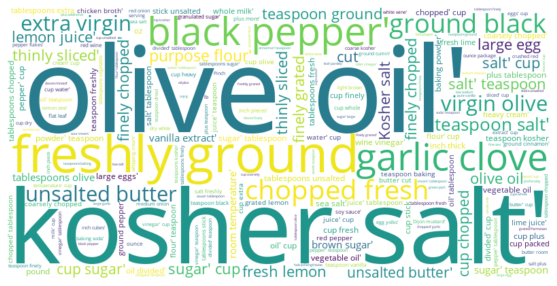

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'field' is the field for which you want to create the word cloud
text = ' '.join(foodrecipes_df['Cleaned_Ingredients'].dropna())  # Join all non-null values in the field into a single string

# Define the path to your font file
font_path = './OpenSans-Regular.ttf'


# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [31]:
# Statistical summaries
#All the columns are strings - statistical sumaries do not make sense.
foodrecipes_df.describe(include='all')

,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients,Cleaned_title
count,13501,13501,13501,13501,13501,13501
unique,13306,13473,13465,13472,13473,13501
top,French 75,[],,#NAME?,[''],Miso-Butter Roast Chicken With Acorn Squash Panzanella
freq,5,12,8,30,12,1


In [32]:
foodrecipes_df.loc[foodrecipes_df['Image_Name']=='#NAME?']
#  There are 30 records that have an incorrect Image_Name as #NAME? Upon a closer look in the original csv file, all the image names for these files start with a hyphen.
#  We will need to strip the hyphen from the Image_Name and replace with a blank.
# We will DELETE THESE!!

,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients,Cleaned_title
Idx,,,,,,
3441,"""Burnt"" Carrots and Parsnips","['1 1/2 pounds carrots, peeled, halved lengthwise, cut into 4"" pieces', '1 1/2 pounds parsnips, peeled, cut into 4"" pieces', '2 tablespoons olive oil', 'Kosher salt, freshly ground pepper', '1/4 medium onion, finely chopped', '4 tablespoons unsalted butter, cut into pieces', '1/4 cup bourbon', '3 tablespoons dark brown sugar']","Preheat oven to 450°F. Toss carrots, parsnips, and oil on a rimmed baking sheet; season with salt and pepper. Roast, tossing occasionally, until tender and charred in spots, 20–25 minutes.\nRemove vegetables from oven, add onion, butter, bourbon, and brown sugar, and toss to coat. Roast, tossing occasionally, until sugars have caramelized and vegetables are completely softened, 8–10 minutes.\nTransfer vegetables to a platter and pour any juices over.",#NAME?,"['1 1/2 pounds carrots, peeled, halved lengthwise, cut into 4"" pieces', '1 1/2 pounds parsnips, peeled, cut into 4"" pieces', '2 tablespoons olive oil', 'Kosher salt, freshly ground pepper', '1/4 medium onion, finely chopped', '4 tablespoons unsalted butter, cut into pieces', '1/4 cup bourbon', '3 tablespoons dark brown sugar']","""Burnt"" Carrots and Parsnips"
3641,"""Bloody Mary"" Tomato Toast with Celery and Horseradish","['1 lemon, zested, juiced', '1/2 shallot, finely chopped', '1 pound grape tomatoes, halved', '2 tablespoons extra-virgin olive oil', '1 tablespoon Sherry vinegar', '1 teaspoon kosher salt', '1 teaspoon freshly ground black pepper', '1 teaspoon Worcestershire sauce', '1/4 teaspoon cayenne pepper', '5 tablespoons finely grated fresh horseradish, divided', '2 celery stalks, thinly sliced', '3 tablespoons coarsely chopped celery leaves', '6 tablespoons mayonnaise', '6 slices toasted rye bread']","Combine lemon zest, lemon juice, shallot, tomatoes, oil, vinegar, salt, black pepper, Worcestershire sauce, cayenne, and 1 Tbsp. horseradish in a large bowl. Let marinate 10 minutes, then stir in celery stalks and leaves.\nMeanwhile, combine mayonnaise and remaining 4 Tbsp. horseradish in a small bowl. Spread 1 Tbsp. horseradish-mayonnaise on each slice of rye. Top toasts evenly with tomato mixture.",#NAME?,"['1 lemon, zested, juiced', '1/2 shallot, finely chopped', '1 pound grape tomatoes, halved', '2 tablespoons extra-virgin olive oil', '1 tablespoon Sherry vinegar', '1 teaspoon kosher salt', '1 teaspoon freshly ground black pepper', '1 teaspoon Worcestershire sauce', '1/4 teaspoon cayenne pepper', '5 tablespoons finely grated fresh horseradish, divided', '2 celery stalks, thinly sliced', '3 tablespoons coarsely chopped celery leaves', '6 tablespoons mayonnaise', '6 slices toasted rye bread']","""Bloody Mary"" Tomato Toast with Celery and Horseradish"
4117,Smoked Salmon Breakfast Salad with Crispbread,"['2 baby beets or radishes, thinly sliced', '8 thin slices red onion (optional)', '6 cups mesclun', '2 tablespoons fresh lemon juice', '2 tablespoons olive oil', '1 tablespoon chopped capers', 'Kosher salt, freshly ground pepper', '0 freshly ground pepper', '3 ounces smoked salmon or gravlax', '3/4 cup Neufchâtel or cream cheese', '4 Wasa crispbread or toasted pumpernickel slices', '1 lemon, cut into wedges']","Toss beets, onion (if using), mesclun, lemon juice, oil, and capers in a large bowl; season with salt and pepper. Add salmon and gently toss to combine. Mound salad alongside crispbread spread with Neufchâtel and serve with lemon wedges for squeezing over.",#NAME?,"['2 baby beets or radishes, thinly sliced', '8 thin slices red onion (optional)', '6 cups mesclun', '2 tablespoons fresh lemon juice', '2 tablespoons olive oil', '1 tablespoon chopped capers', 'Kosher salt, freshly ground pepper', '0 freshly ground pepper', '3 ounces smoked salmon or gravlax', '3/4 cup Neufchâtel or cream cheese', '4 Wasa crispbread or toasted pumpernickel slices', '1 lemon', 'cut into wedges']",Smoked Salmon Breakfast Salad wi

In [33]:
# Drop all the rows that have #NAME? Image_name, since they are actual images, but are coming thru incorrectly. 
foodrecipes_df = foodrecipes_df.drop(foodrecipes_df[foodrecipes_df['Image_Name']=='#NAME?'].index)

In [34]:
# if '#NAME?' in foodrecipes_df['Image_Name'].values:
#     # Select rows where 'Image_Name' is '#NAME?'
#     rows_to_rename = foodrecipes_df.loc[foodrecipes_df['Image_Name'] == '#NAME?']
#     # Rename the 'Image_Name' column for selected rows with the 'Title' value
#     foodrecipes_df.loc[rows_to_rename.index, 'Image_Name'] = foodrecipes_df.loc[rows_to_rename.index, 'Title']
# foodrecipes_df.iloc[3441]

In [35]:
foodrecipes_df.shape

(13471, 6)

In [36]:
foodrecipes_df.iloc[74]
t=foodrecipes_df.iloc[74]['Title']
langid.classify(t)
t1='Plátanos Horneados con Crema y Queso (Baked Banana With Crema and Cheese)'
if langid.classify(t)[0] != 'en':
    print(t)

Doenjang Jjigae (된장찌개 / Fermented-Soybean Stew)


In [37]:
#  Identify and drop records that have non-english script in the titlename. 
#  Limitation of our app: Currently we will only handle recipes in English.
english_mask = foodrecipes_df['Title'].apply(contains_english)

# Filter English rows; create new df to store cleaned rows
foodrecipescleaned_df = foodrecipes_df[english_mask]

print(foodrecipescleaned_df['Title'])

Idx
0                     Miso-Butter Roast Chicken With Acorn Squash Panzanella
1                                            Crispy Salt and Pepper Potatoes
2                                                Thanksgiving Mac and Cheese
3                                         Italian Sausage and Bread Stuffing
4                                                               Newton's Law
                                        ...                                 
13495                               Dandelion Salad with Warm Bacon Dressing
13497     Israeli Couscous with Roasted Butternut Squash and Preserved Lemon
13498                    Rice with Soy-Glazed Bonito Flakes and Sesame Seeds
13499                                                            Spanakopita
13500    Mexican Poblano, Spinach, and Black Bean "Lasagne" with Goat Cheese
Name: Title, Length: 10344, dtype: object


In [38]:
foodrecipescleaned_df.shape
# After dropping rows that did not conform to our standard of english-script-only recipes, left with 10,344 records.

(10344, 6)

In [39]:
d = foodrecipescleaned_df.copy()
d['Cleaned_Ingredients'] = d['Cleaned_Ingredients'].apply(eval)
d.head()

,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients,Cleaned_title
Idx,,,,,,
0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups)', '2 medium apples (such as Gala or Pink Lady; about 14 oz. total), cored, cut into 1"" pieces', '2 Tbsp. extra-virgin olive oil', '½ small red onion, thinly sliced', '3 Tbsp. apple cider vinegar', '1 Tbsp. white miso', '¼ cup all-purpose flour', '2 Tbsp. unsalted butter, room temperature', '¼ cup dry white wine', '2 cups unsalted chicken broth', '2 tsp. white miso', 'Kosher salt, freshly ground pepper']","Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine. Let sit at room temperature 1 hour.\nMeanwhile, halve squash and scoop out seeds. Run a vegetable peeler along ridges of squash halves to remove skin. Cut each half into ½""-thick wedges; arrange on a rimmed baking sheet.\nCombine sage, rosemary, and 6 Tbsp. melted butter in a large bowl; pour half of mixture over squash on baking sheet. Sprinkle squash with allspice, red pepper flakes, and ½ tsp. salt and season with black pepper; toss to coat.\nAdd bread, apples, oil, and ¼ tsp. salt to remaining herb butter in bowl; season with black pepper and toss to combine. Set aside.\nPlace onion and vinegar in a small bowl; season with salt and toss to coat. Let sit, tossing occasionally, until ready to serve.\nPlace a rack in middle and lower third of oven; preheat to 425°F. Mix miso and 3 Tbsp. room-temperature butter in a small bowl until smooth. Pat chicken dry with paper towels, then rub or brush all over with miso butter. Place chicken in a large cast-iron skillet and roast on middle rack until an instant-read thermometer inserted into the thickest part of breast registers 155°F, 50–60 minutes. (Temperature will climb to 165°F while chicken rests.) Let chicken rest in skillet at least 5 minutes, then transfer to a plate; reserve skillet.\nMeanwhile, roast squash on lower rack until mostly tender, about 25 minutes. Remove from oven and scatter reserved bread mixture over, spreading into as even a layer as you can manage. Return to oven and roast until bread is golden brown and crisp and apples are tender, about 15 minutes. Remove from oven, drain pickled onions, and toss to combine. Transfer to a serving dish.\nUsing your fingers, mash flour and butter in a small bowl to combine.\nSet reserved skillet with chicken drippings over medium heat. You should have about ¼ cup, but a little over or under is all good. (If you have significantly more, drain off and set excess aside.) Add wine and cook, stirring often and scraping up any browned bits with a wooden spoon, until bits are loosened and wine is reduced by about half (you should be able to smell the wine), about 2 minutes. Add butter mixture; cook, stirring often, until a smooth paste forms, about 2 minutes. Add broth and any reserved drippings and cook, stirring constantly, until combined and thickened, 6–8 minutes. Remove from heat and stir in miso. Taste and season with salt and black pepper.\nServe chicken with gravy and squash panzanella alongside.",miso-butter-roast-chicken-acorn-squash-panzanella,"[1 (3½–4-lb.) whole chicken, 2¾ tsp. kosher salt, divided, plus more, 2 small acorn squash (about 3 lb. total), 2 Tbsp. finely chopped sage, 1 Tbsp. finely chopped rosemary, 6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature, ¼ tsp. ground allspice, Pinch of crushed red pepper flakes, Freshly ground black pepper, ⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups), 2 medium a

In [40]:
foodrecipescleaned_df.shape

(10344, 6)

In [41]:
# Update the Image_Name column in the DataFrame with the new title names
foodrecipescleaned_df['Image_Name'] = foodrecipescleaned_df['Cleaned_title'].replace('"', '_')

C:\Users\Savitha\AppData\Local\Temp\ipykernel_13420\3274081670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodrecipescleaned_df['Image_Name'] = foodrecipescleaned_df['Cleaned_title'].replace('"', '_')


## Prepping the dataset for image generation

### Splitting the string in the Instructions and Cleaned_ingredients columns into sentences and storing it in one column to enable easier looping and generation for images.

### Combining split sentences of ingredients and instructions into one column by title.

In [42]:
import ast
import json

import spacy

# Load the English language model in spacy
nlp = spacy.load('en_core_web_sm')

# Define batch size
batch_size = 100

# Initialize an empty list to store DataFrames for each batch
batch_dfs = []

# Process rows in batches
for start_index in range(0, len(foodrecipescleaned_df), batch_size):
    end_index = min(start_index + batch_size, len(foodrecipescleaned_df))
    batch_df = foodrecipescleaned_df.iloc[start_index:end_index].copy()  # Make a copy of the batch DataFrame
    # Drop unnecessary columns: Ingredients
    batch_df.drop(columns=['Ingredients'], inplace=True)
    
    # Tokenize sentences in the 'Instructions' column
    batch_df['Instructions'] = batch_df['Instructions'].astype(str).apply(lambda x: [sent.text.strip() for sent in nlp(x).sents])
   
    # Convert string representation of list to list
    batch_df['Cleaned_Ingredients'] = batch_df['Cleaned_Ingredients'].apply(eval)

    batch_df['image_path'] = img_path + "\\" + foodrecipescleaned_df['Image_Name'] + ".jpg"
    
    # Separate cleaned ingredients and instructions into separate DataFrames
    instructions_df = batch_df.explode('Instructions')[['Cleaned_title', 'Instructions', 'Image_Name', 'image_path']].copy()
    cleaned_ingredients_df = batch_df.explode('Cleaned_Ingredients')[['Cleaned_title', 'Cleaned_Ingredients', 'Image_Name', 'image_path']].copy()

    # Rename the columns for concatenation
    instructions_df.columns = ['Title', 'Recipe', 'Image_Name', 'image_path']
    cleaned_ingredients_df.columns = ['Title', 'Recipe', 'Image_Name', 'image_path']

    # Add a column to differentiate between cleaned ingredients and instructions
    instructions_df['Type'] = 'Instructions'
    cleaned_ingredients_df['Type'] = 'Cleaned Ingredients'
    
    # Concatenate the DataFrames and append to the list
    batch_dfs.append(pd.concat([cleaned_ingredients_df, instructions_df], ignore_index=True))


# Concatenate the DataFrames vertically
combined_df = pd.concat(batch_dfs, ignore_index=True)

# # Print the resulting DataFrame
# print(combined_df)
# # Print total number of rows processed
# print("Total number of rows processed:", len(combined_df))


## Addnl. Visualizations

In [43]:
combined_df.dropna(inplace=True)
# Print total number of rows processed
print("Total number of rows processed:", len(combined_df))

Total number of rows processed: 272156


In [44]:
#  This will be the final 
combined_df.head()

,Title,Recipe,Image_Name,image_path,Type
0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,1 (3½–4-lb.) whole chicken,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
1,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"2¾ tsp. kosher salt, divided, plus more",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
2,Miso-Butter Roast Chicken With Acorn Squash Panzanella,2 small acorn squash (about 3 lb. total),Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
3,Miso-Butter Roast Chicken With Acorn Squash Panzanella,2 Tbsp. finely chopped sage,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
4,Miso-Butter Roast Chicken With Acorn Squash Panzanella,1 Tbsp. finely chopped rosemary,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients


In [45]:
ingredients_df = combined_df[combined_df['Type'] == 'Cleaned Ingredients']

ingredients_df.head(50)

,Title,Recipe,Image_Name,image_path,Type
0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,1 (3½–4-lb.) whole chicken,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
1,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"2¾ tsp. kosher salt, divided, plus more",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
2,Miso-Butter Roast Chicken With Acorn Squash Panzanella,2 small acorn squash (about 3 lb. total),Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
3,Miso-Butter Roast Chicken With Acorn Squash Panzanella,2 Tbsp. finely chopped sage,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
4,Miso-Butter Roast Chicken With Acorn Squash Panzanella,1 Tbsp. finely chopped rosemary,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
5,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
6,Miso-Butter Roast Chicken With Acorn Squash Panzanella,¼ tsp. ground allspice,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
7,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Pinch of crushed red pepper flakes,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
8,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Freshly ground black pepper,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
9,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups)",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients


In [46]:
instructions_df = combined_df[combined_df['Type'] == 'Instructions']
instructions_df.head(50)

,Title,Recipe,Image_Name,image_path,Type
1202,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine.",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions
1203,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Let sit at room temperature 1 hour.,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions
1204,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"Meanwhile, halve squash and scoop out seeds.",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions
1205,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Run a vegetable peeler along ridges of squash halves to remove skin.,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions
1206,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"Cut each half into ½""-thick wedges; arrange on a rimmed baking sheet.",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions
1207,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"Combine sage, rosemary, and 6 Tbsp.",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions
1208,Miso-Butter Roast Chicken With Acorn Squash Panzanella,melted butter in a large bowl; pour half of mixture over squash on baking sheet.,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions
1209,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"Sprinkle squash with allspice, red pepper flakes, and ½ tsp. salt and season with black pepper; toss to coat.",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions
1210,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"Add bread, apples, oil, and ¼ tsp. salt to remaining herb butter in bowl; season with black pepper and toss to combine.",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions
1211,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Set aside.,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Instructions


In [47]:
# Create a new DataFrame to store only the ingredients (apply preprocess_recipe to strip out other stuff)
only_ingredients_df = pd.DataFrame({
    'ingredients': ingredients_df['Recipe'].apply(preprocess_recipe)
})

In [48]:
only_ingredients_df

,ingredients
0,chicken
1,salt
2,squash
3,sage
4,
...,...
271485,olive oil
271486,corn tortillas
271487,beans
271488,pine nuts


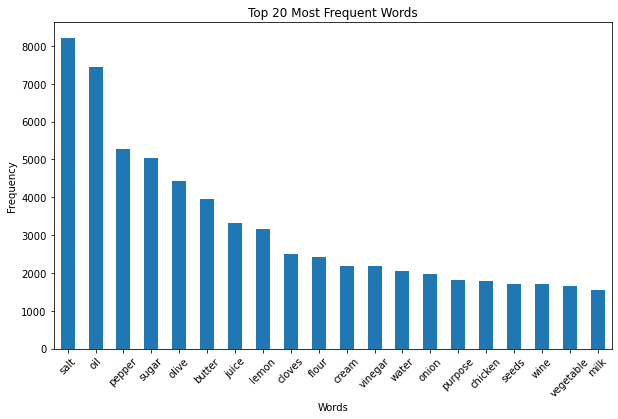

In [49]:
# Plot word frequencies for the 'Cleaned_Recipe' column in cleaned_recipes_df
plot_word_frequencies(only_ingredients_df, 'ingredients')

In [50]:
#  average number of instructions across all recipes
average_rows_per_title_instructions = instructions_df.groupby('Title').size().mean()

# Find the maximum number of instructions and the recipe associated with it
max_instructions = instructions_df.groupby('Title').size().idxmax()
max_instructions_count = instructions_df.groupby('Title').size().max()

# Find the minimum number of instructions and the recipe associated with it
min_instructions = instructions_df.groupby('Title').size().idxmin()
min_instructions_count = instructions_df.groupby('Title').size().min()


In [51]:
print("Average number of instructions associated with each title:", round(average_rows_per_title_instructions, 2))
print("Recipe with the maximum number of instructions:", max_instructions)
print("Maximum number of instructions:", max_instructions_count)
print("Recipe with the minimum number of instructions:", min_instructions)
print("Minimum number of instructions:", min_instructions_count)


Average number of instructions associated with each title: 15.09
Recipe with the maximum number of instructions: Basic Brioche_9167
Maximum number of instructions: 155
Recipe with the minimum number of instructions: Apple Pie Smoothie
Minimum number of instructions: 1


### Topic Modeling

Topic 1: oil, olive, chicken, cheese, parsley, egg, broth, cilantro, leaf, chocolate
Topic 2: butter, cloves, onion, milk, vanilla, sauce, stick, temperature, room, extract
Topic 3: pepper, flour, oil, purpose, vegetable, seeds, eggs, clove, flakes, celery
Topic 4: lemon, juice, vinegar, cream, water, wine, tomatoes, thyme, rice, sprigs
Topic 5: salt, sugar, lime, sea, ginger, juice, wedges, bread, mint, orange


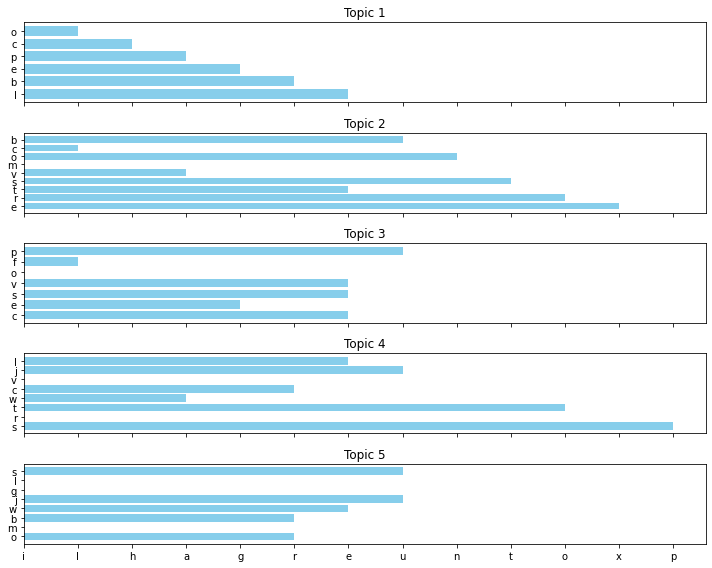

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


documents = only_ingredients_df['ingredients'].astype(str) # 

# Step 1: Vectorize the text data
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(documents)

# Step 2: Apply Latent Dirichlet Allocation (LDA)
num_topics = 5  # You can adjust this based on your preference
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Step 3: Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = []
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_words_per_topic.append(top_words)

# Display the top words for each topic
for i, top_words in enumerate(top_words_per_topic):
    print(f"Topic {i + 1}: {', '.join(top_words)}")

# Step 4: Visualize the results
def plot_top_words_per_topic(top_words_per_topic):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, 8), sharex=True)
    for i, top_words in enumerate(top_words_per_topic):
        words = [word[0] for word in top_words]  # Extracting words from (word, score) tuples
        scores = [word[1] for word in top_words]  # Extracting scores from (word, score) tuples
        axes[i].barh(words, scores, color='skyblue')
        axes[i].invert_yaxis()
        axes[i].set_title(f'Topic {i + 1}')
    plt.tight_layout()
    plt.show()

plot_top_words_per_topic(top_words_per_topic)


In [53]:
# save the list of ingredients to a file
#     with open("all_ingredients.txt", "w", encoding="utf-8") as file:
#         for ingredient in all_ingredients:
#             file.write(ingredient + "\n") 


# with open("ingredients_dict.json", "w") as file:
#     json.dump(ingredients_dict, file)

### Topic Modeling 2

In [54]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

# seed
seed = 9527

# image size
IMAGE_SIZE = [256, 256]

# Label_dim
label_dim = 1

# common_allergens list
common_allergens = {
    'milk': {'Cheese', 'Butter', 'Margarine', 'Yogurt', 'Cream', 'Ice cream'},
    'meat': {'beef', 'pork', 'lamb', 'bacon', 'sausage'},
    'eggs': {'egg'},
    'tree nuts': {'Brazil nut', 'Almond', 'Cashew', 'Macadamia nut', 'Pistachio','Pine nut','Walnut'},
    'peanuts': {'peanut'},
    'shellfish': {'Shrimp','Prawn','Crayfish', 'Lobster', 'Squid', 'Scallops'},
    'wheat': {'flour', 'wheat', 'pasta', 'noodle', 'bread', 'crust'},
    'soy': {'soy', 'tofu', 'soya'},
    'fish': {'fish', 'seafood'}
}

# Targets list
targets = allergens = ["milk", "meat", "eggs", "tree nuts", "peanuts", "shellfish", "wheat", "soy", "fish"]

diet_categories = {
    'vegan': {},
    'vegetarian': {},
    'pescatarian': {},
    'meat': {}
}

RGB_FLIP = 1 # should rgb be flipped when rendering images

In [55]:
# Apply the function to create a new column for each allergen type
for allergen_type in common_allergens.keys():
    foodrecipescleaned_df.loc[:, allergen_type] = foodrecipescleaned_df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, allergen_type))

print(foodrecipescleaned_df.head())

C:\Users\Savitha\AppData\Local\Temp\ipykernel_13420\195629837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodrecipescleaned_df.loc[:, allergen_type] = foodrecipescleaned_df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, allergen_type))
C:\Users\Savitha\AppData\Local\Temp\ipykernel_13420\195629837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodrecipescleaned_df.loc[:, allergen_type] = foodrecipescleaned_df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, allergen_typ

                                                      Title  \
Idx                                                           
0    Miso-Butter Roast Chicken With Acorn Squash Panzanella   
1                           Crispy Salt and Pepper Potatoes   
2                               Thanksgiving Mac and Cheese   
3                        Italian Sausage and Bread Stuffing   
4                                              Newton's Law   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

C:\Users\Savitha\AppData\Local\Temp\ipykernel_13420\195629837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodrecipescleaned_df.loc[:, allergen_type] = foodrecipescleaned_df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, allergen_type))
C:\Users\Savitha\AppData\Local\Temp\ipykernel_13420\195629837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodrecipescleaned_df.loc[:, allergen_type] = foodrecipescleaned_df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, allergen_typ

In [56]:
# Plotting
allergen_counts = foodrecipescleaned_df.drop(columns=['Title', 'Ingredients', 'Instructions', 'Image_Name', 'Cleaned_Ingredients', 'Cleaned_title']).sum()

In [57]:
print(allergen_counts.head())

milk         5245
meat         1543
eggs         2688
tree nuts    1177
peanuts       320
dtype: int64


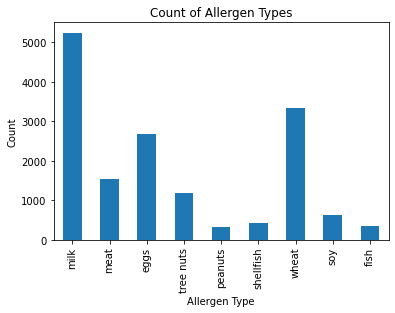

In [58]:
# Plotting
allergen_counts.plot(kind='bar')
plt.xlabel('Allergen Type')
plt.ylabel('Count')
plt.title('Count of Allergen Types')
plt.show()

In [59]:
combined_df.describe

<bound method NDFrame.describe of                                                                       Title  \
0                    Miso-Butter Roast Chicken With Acorn Squash Panzanella   
1                    Miso-Butter Roast Chicken With Acorn Squash Panzanella   
2                    Miso-Butter Roast Chicken With Acorn Squash Panzanella   
3                    Miso-Butter Roast Chicken With Acorn Squash Panzanella   
4                    Miso-Butter Roast Chicken With Acorn Squash Panzanella   
...                                                                     ...   
272159  Mexican Poblano, Spinach, and Black Bean "Lasagne" with Goat Cheese   
272160  Mexican Poblano, Spinach, and Black Bean "Lasagne" with Goat Cheese   
272161  Mexican Poblano, Spinach, and Black Bean "Lasagne" with Goat Cheese   
272162  Mexican Poblano, Spinach, and Black Bean "Lasagne" with Goat Cheese   
272163  Mexican Poblano, Spinach, and Black Bean "Lasagne" with Goat Cheese   

                 

In [60]:
# Re-indexing the DataFrame
combined_df_reindexed = combined_df.reset_index(drop=True)
combined_df_reindexed.head()

,Title,Recipe,Image_Name,image_path,Type
0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,1 (3½–4-lb.) whole chicken,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
1,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"2¾ tsp. kosher salt, divided, plus more",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
2,Miso-Butter Roast Chicken With Acorn Squash Panzanella,2 small acorn squash (about 3 lb. total),Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
3,Miso-Butter Roast Chicken With Acorn Squash Panzanella,2 Tbsp. finely chopped sage,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
4,Miso-Butter Roast Chicken With Acorn Squash Panzanella,1 Tbsp. finely chopped rosemary,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients


In [61]:
combined_df_reindexed[combined_df_reindexed['Type']=='Cleaned Ingredients']['Recipe']

0                                                                     1 (3½–4-lb.) whole chicken
1                                                        2¾ tsp. kosher salt, divided, plus more
2                                                       2 small acorn squash (about 3 lb. total)
3                                                                    2 Tbsp. finely chopped sage
4                                                                1 Tbsp. finely chopped rosemary
                                                   ...                                          
271477                                                                   3 tablespoons olive oil
271478                                                         6 (6-inch) corn tortillas, halved
271479                                    1 cup cooked black beans, rinsed and drained if canned
271480                                                                Garnish: toasted pine nuts
271481    a 2- to 2 1/2-quart 

In [62]:
combined_df_reindexed.head(10)
# load_dataset(combined_df_reindexed)  #df, train_df, val_df = 

,Title,Recipe,Image_Name,image_path,Type
0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,1 (3½–4-lb.) whole chicken,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
1,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"2¾ tsp. kosher salt, divided, plus more",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
2,Miso-Butter Roast Chicken With Acorn Squash Panzanella,2 small acorn squash (about 3 lb. total),Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
3,Miso-Butter Roast Chicken With Acorn Squash Panzanella,2 Tbsp. finely chopped sage,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
4,Miso-Butter Roast Chicken With Acorn Squash Panzanella,1 Tbsp. finely chopped rosemary,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
5,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
6,Miso-Butter Roast Chicken With Acorn Squash Panzanella,¼ tsp. ground allspice,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
7,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Pinch of crushed red pepper flakes,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
8,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Freshly ground black pepper,Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients
9,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups)",Miso-Butter Roast Chicken With Acorn Squash Panzanella,Food Recipes\Food Images\Miso-Butter Roast Chicken With Acorn Squash Panzanella.jpg,Cleaned Ingredients


In [63]:
combined_df_reindexed.shape

(272156, 5)